# Homework 2: This HW is based on the code for House Price Feature Selection and LASSO Regularization

## Instructions: 

Place the answer to your code only in the area specified. Also, make sure to run all your code (e.g., if you are running the code on your local machine, press >> to "Restart Kernel and Run All Cells"). This should plot all outputs including your answers to homework questions. After this, go to file (top left) and select "Print". Save your file as a PDF and upload the PDF to Canvas. This is one way to generate a PDF. You can also search for other methods to generate a PDF from Jupyter.

## Question 1 (2 points):
Discuss the concept of regularization in machine learning. Explain how regularization techniques such as Ridge Regression and Lasso Regression help mitigate overfitting?

Regularization in machine learning helps prevent overfitting of the model and helps it behave more accurately on real data. Regularization adds a penalty to the feature variables to make the models simpler. Ridge regression tends to lead to many small coefficients, that aren't exactly zero. This is not ideal for feature selection. On the other hand, LASSO regression pushes many coefficients to zero, which leads to more sparse solutions.

## Question 2 (2 points):
Provide a brief summary of Elastic net regularization? You can consult wikipedia or other online sources to study this topic.

ElasticNet regularization combines Ridge and LASSO regularization by adding both penalties to the loss function. It provides a balance between both, offering both of their benefits. A typical loss function for an ElasticNet regularization would have the form:


$$ \text{Objective} = \text{Loss} + \lambda_1 \sum_{i=1}^{p} |\beta_i| + \lambda_2 \sum_{i=1}^{p} \beta_i^2 $$

Where:
- $\text{Loss}$ is the original loss function.
- $\lambda_1$ and $\lambda_2$ are the regularization parameters that control the strength of the Ridge and LASSO penalties, respectively.
- $|\beta_i|$ represents the absolute value of the $i$-th coefficient (Ridge penalty).
- $\beta_i^2$ represents the squared value of the $i$-th coefficient (LASSO penalty).
- $p$ is the number of features.


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


## Downloading and Cleaning the Data

On the Kaggle competition site, you can download a train data set (with labels) and a test data set (with no labels).  Here, we will just use the train dataset since it has labels that we can use to assess the results.  Later, we will split that dataset into training and test. 

In [54]:
fn_src = 'https://raw.githubusercontent.com/earyafar/IntroML/main/housing_train.csv'
fn_dst = 'housing_train.csv'

import os
from six.moves import urllib

if os.path.isfile(fn_dst):
    print('File %s is already downloaded' % fn_dst)
else:
    urllib.request.urlretrieve(fn_src, fn_dst)

File housing_train.csv is already downloaded


We then load the file into a pandas dataframe and display the data.  

In [55]:
df = pd.read_csv('housing_train.csv')

We print the number of attributes and samples.  We see that there are a large number of attributes for each home sale.

In [56]:
nsamp, natt = df.shape
print(f"Number of samples: {nsamp}")
print(f"Number of attributes: {natt}")

Number of samples: 1460
Number of attributes: 81


Before we proceed, we need to remove the columns with missing values. We see that we remove about 19 attributes.

In [57]:
df = df.dropna(axis=1)

nsamp, natt = df.shape


It is suggested in DeCock's [paper](http://jse.amstat.org/v19n3/decock.pdf), that to make the regression easier, we remove all the entries where the `SaleCondition` was not normal.  We do this with the following code which should leave us with 1198 samples.

In [58]:
df = df.loc[df['SaleCondition'] == 'Normal']

nsamp, natt = df.shape
print('Number samples = %d' % nsamp)
print('Number attributes per sample = %d' % natt)

Number samples = 1198
Number attributes per sample = 62


## One-Hot Coding the Categorical Variables


We want to one hot code all the categorical variables.  As a first step, a first list `cat_vars` with all the categorical variables and `real_vars` with the real variables (i.e. non-categorical).   In both lists we do not include the variables `ignore_vars` which include the index, month of the sale or sales price (the sales price) will be used as the target.

In [59]:
# Remove the ID, month sold and sales price (it is the target)
ignore_vars = ['Id', 'MoSold', 'SalePrice']

# Find real and categorical variables
cols = df.columns
cat_vars = []
real_vars = []

for col in cols:
    
    if not (col in ignore_vars):
        if df.dtypes[col]  == 'object':
            cat_vars.append(col)
        else:
            real_vars.append(col)

We next one-hot coded categorical variables.  To do this, we use the `pd.get_dummies` command to convert the categorical variables to one hot coded items.   We use the `drop_first=True` to replace each category with `k` values to `k-1` variables.  This removes linearly dependent columns.

In [60]:
# Get the dataframes with real and categorical variables
df_real = df[real_vars]
df_cat = df[cat_vars]

# One-hot encode the categorical variables
df_cat_enc = pd.get_dummies(df_cat, drop_first=True)

To see how the one hot coding worked, we print out the original categorical table, `df_cat` and the one hot coded variables `df_cat_enc`.  Observe how a variable like `MSZoning` is converted to multiple columns like `MSZoning_C`, `MSZoning_FV`, ..., `MSZoning_RM` corresponding to each possible value.  

To get the data matrix, we then concatanate the real and encoded categorical tables and convert to an array.  We see there are now 214 attributes.

In [61]:
df_enc = pd.concat((df_real, df_cat_enc), axis=1)
X = np.array(df_enc)
print(X.shape)

xnames = df_enc.columns

(1198, 174)


To get the target we extract the sales price.

In [62]:
y = np.array(df['SalePrice'])


## Scaling the Data

We will try to fit a model with simple linear regression.   We first split the data into training and test.

In [63]:
from sklearn.model_selection import train_test_split

Xtr, Xts, ytr, yts = train_test_split(X,y,test_size=0.3)

A feature of this data is that the attributes have very different ranges of values.  Many methods below expect that the variables have similar ranges.  For this purpose we use sklearn's `StandardScaler` which removes the mean from each column and divides by the standard deviation.  We fit the parameters for the scaler on the training data and then apply the transform to the training and test data.

Technically, we do not need to scale the output, but it will make the variables easier to interpret.

In [64]:
from sklearn.preprocessing import StandardScaler

# Create the scaler objects
xscal = StandardScaler()
yscal = StandardScaler()

# Fit and transform the training data
Xtr1 = xscal.fit_transform(Xtr)
ytr1 = yscal.fit_transform(ytr[:,None])

# Transform the test data
Xts1 = xscal.transform(Xts)
yts1 = yscal.transform(yts[:,None])

## Linear Regression without Regualarization

We first fit the model with linear regression on the scaled training data.  Then, we predict on the test data and measure the R^2 value.  We get a terrible fit.

In [65]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score

# Fit
reg_ls = LinearRegression()
reg_ls.fit(Xtr1, ytr1)

# Training R^2
yhat1_tr = reg_ls.predict(Xtr1)
rsq_tr = r2_score(yhat1_tr, ytr1)
print('Training R^2 = %12.4e' % rsq_tr)

# Test R^2
yhat1_ts = reg_ls.predict(Xts1)
rsq_ts = r2_score(yts1, yhat1_ts)
print('Test R^2     = %12.4e' % rsq_ts)




Training R^2 =   9.4018e-01
Test R^2     =  -7.4257e+21


We get a terrible fit.  The reason is that the matrix is ill-conditioned, meaning some of the columns in the data matrix `Xtr` are linearly dependent.  We can get a better fit if we use a method called *Ridge regression*.  Ridge regression is a type of regularization that we will discuss later, but we will use it here simply to improve the conditioning.  

To understand Ridge regression, recall that the solution of the LS problem is:

    beta = inv(A.T.dot(A)).dot(A.T.dot(y))
    
The problem occurs when the matrix, `A.T.dot(A)` has eigenvalues close to zero so the inverse blows up.  To avoid, Ridge regression instead computes,

    beta = inv(A.T.dot(A) + n*alpha*eye(n)).dot(A.T.dot(y))

where `n` is the number of data samples and `alpha` is a small value to keep the eigenvalues positive.  Ridge regression can be performed as follows.

In [66]:
reg_ls = Ridge(alpha=1e-5)
reg_ls.fit(Xtr1, ytr1)
yhat1 = reg_ls.predict(Xts1)
rsq = r2_score(yts1, yhat1)
print('Test R^2     = %f' % rsq)

Test R^2     = 0.894874


We see we get a good fit.  We can also plot the actual vs. predicted values.  To do this, we convert the predicted targets back to the original scaling with the `inverse_transform` method in the scaler.

Text(0, 0.5, 'Actual')

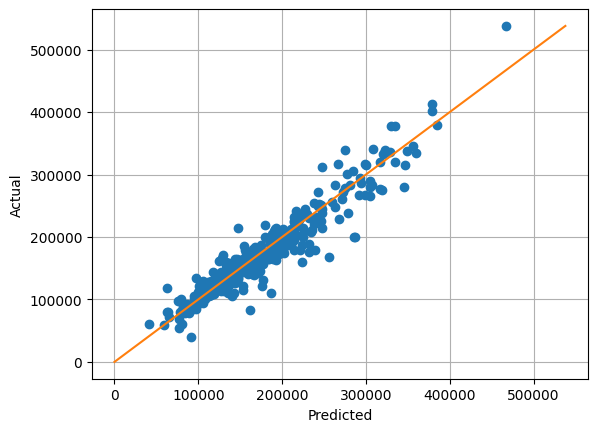

In [67]:
yhat = yscal.inverse_transform(yhat1)

yline = np.array([0, np.max(yts)])
plt.plot(yhat, yts, 'o')
plt.plot(yline, yline)
plt.grid()
plt.xlabel('Predicted')
plt.ylabel('Actual')



To understand which variables are important, we may find the variables with the largest coefficients.  We see that the among the top 10 coefficients, attributes such as square footage (SF) and quality dominate.

In [68]:
coeff_ls = reg_ls.coef_.ravel()
nprint = 10
I = np.argsort(np.abs(coeff_ls))
I = np.flipud(I)
for i in range(nprint):
    j = I[i]
    print('%20s %f' % (xnames[j], coeff_ls[j]) )

           GrLivArea 0.288268
 Exterior2nd_VinylSd 0.264003
            2ndFlrSF 0.245636
         MSZoning_RL 0.224187
      KitchenQual_Gd -0.198783
      KitchenQual_TA -0.189988
 Exterior1st_VinylSd -0.173995
         MSZoning_RM 0.162316
        ExterQual_TA -0.158093
        ExterQual_Gd -0.151719


We can also try to find the variables that do not matter.  But, this is harder since it appears that most coefficients are non-zero. We can see this from both the stem plot (left) and the sorted coefficients (right).  It is hard to discard any coefficients.

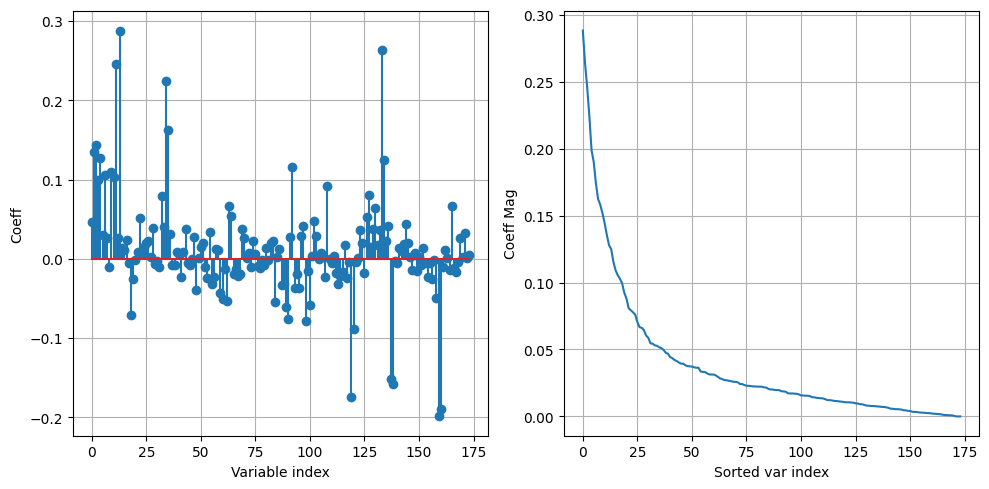

In [69]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.stem(coeff_ls)
plt.xlabel('Variable index')
plt.ylabel('Coeff')
plt.grid()


plt.subplot(1,2,2)
coeff_sort_ls = np.flipud(np.sort(np.abs(coeff_ls)))
plt.plot(coeff_sort_ls)
plt.xlabel('Sorted var index')
plt.ylabel('Coeff Mag')
plt.grid()
plt.tight_layout()



## Question 3 (3 points):
Re-train the model with the variables with the largest 50 values in `coeff_ls`.  What is the test R^2?

In [77]:
mod_coeff_ls = np.zeros(len(coeff_ls))
largest_indexes = np.argpartition(mod_coeff_ls, -50)[-50: ]
mod_coeff_ls[largest_indexes] = coeff_ls[largest_indexes]

reg_ls2 = reg_ls
reg_ls2.coef_ = mod_coeff_ls

reg_ls2.fit(Xtr1, ytr1)
yhat2 = reg_ls2.predict(Xts1)
rsq2 = r2_score(yts1, yhat2)

print('Test R^2     = %f' % rsq2)

Test R^2     = 0.894874


## Question 4 (3 points):
In all of the above code, we set the value of alpha in ridge regression to "alpha=1e-5". In general, the optimal value of alpha should be found through cross validation. Write down the appropriate lines of code to perform 10 fold cross validation, and let alpha vary, i.e., "alphas = np.logspace(-6,-1,50)". Plot the test R^2 versus log10(alpha) including the error bars for each data point. What is the optimal value of alpha?


Optimal Alpha: 0.1
log10(Optimal Alpha): -1.0


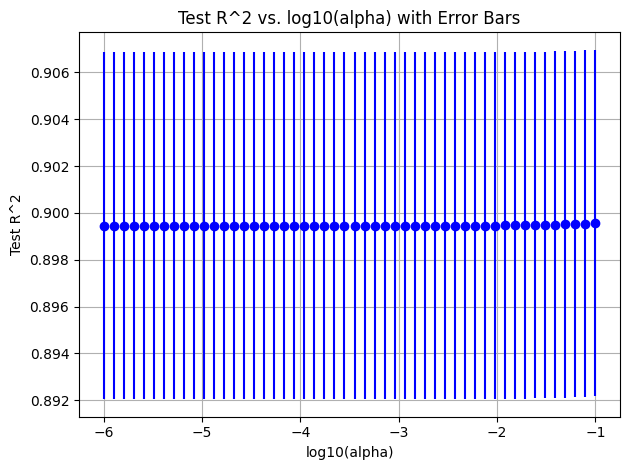

In [110]:
from sklearn.model_selection import KFold
import math

alphas = np.logspace(-6,-1,50)
nalpha = len(alphas)
nfold = 10

kf = KFold(n_splits = 10)

rsq = np.zeros((nalpha, nfold))
for ifold, ind in enumerate(kf.split(X)):
    
    Itr, Its = ind
    Xtr = X[Itr, :]
    ytr = y[Itr]
    Xts = X[Its, :]
    yts = y[Its]

    Xtr1 = xscal.fit_transform(Xtr)
    Xts1 = xscal.transform(Xts)
    ytr1 = yscal.fit_transform(ytr[:, None])
    yts1 = yscal.transform(yts[:, None])

    for i, alpha in enumerate(alphas):
        reg = Ridge(alpha = alpha)
        reg.fit(Xtr1, ytr1)

        yhat1 = reg.predict(Xts1)
        rsq[i, ifold] = r2_score(yts1, yhat1)

rsq_mean = np.mean(rsq, axis=1)
rsq_se = np.std(rsq, axis=1) / np.sqrt(nfold-1)

# print(rsq, rsq_mean, rsq_se)

optimal_alpha = np.argmax(rsq_mean)
print(f"Optimal Alpha: {alphas[optimal_alpha]}\nlog10(Optimal Alpha): {np.log10(alphas[optimal_alpha])}")



plt.errorbar(np.log10(alphas), rsq_mean, yerr=rsq_se, fmt='o', color='b')
plt.xlabel('log10(alpha)')
plt.ylabel('Test R^2')
plt.title('Test R^2 vs. log10(alpha) with Error Bars')
plt.grid(True)
plt.tight_layout()